In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import bayesian_model as bm
import emcee
import corner
from scipy.optimize import curve_fit

#### Color code: Datapoints + errorbars blue, total fit (MAP for example) in orange C1, peak fit in green, background fit in red

#### TODO: See comments

In [2]:
# Get the data from the file
def get_data(filename):
    data = pd.read_csv(filename, sep=',')
    data = data.dropna()
    data = data[(data['Q1'] + data['Q2']) == 0]
    
    M_data = data['M'].values

    y, bins, _ = plt.hist(M_data, bins=200, range=(45,110), alpha=0.5, label='Histogram of the data')
    #plt.close()
    x = 0.5*(bins[1:]+bins[:-1])
    y_errors = np.sqrt(y) # Assuming Poisson statistics for the errors ----MAYBE ASK ABOUT THIS----

    return x, y, y_errors

def plot_data(x, y, y_errors):
    plt.errorbar(x, y, yerr=y_errors, fmt ='.', color = 'b', label='Data - at bin centers')
    plt.plot(x, y, '.',linewidth=0.5, color = 'black')
    plt.xlabel('Invariant mass [GeV]')
    plt.ylabel('Number of events')
    plt.grid()
    plt.legend()
    plt.show()

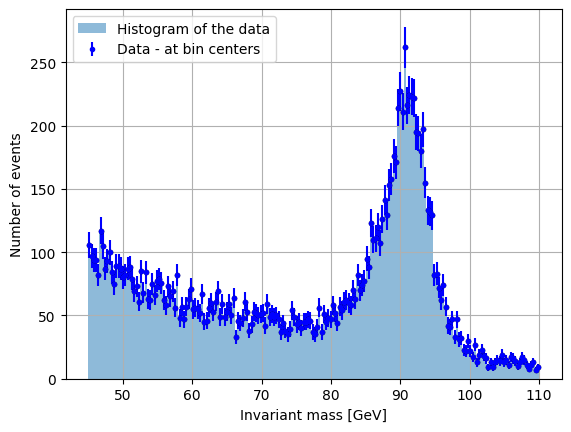

In [3]:
filename = 'dielectron.csv'
x, y, y_errors = get_data(filename)
plot_data(x, y, y_errors)


c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:64: RuntimeWarning: invalid value encountered in power
  return np.where(z > -alpha, N * np.exp(-z**2 / 2), N * A * (B - z)**-n)
c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:56: RuntimeWarning: invalid value encountered in scalar power
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


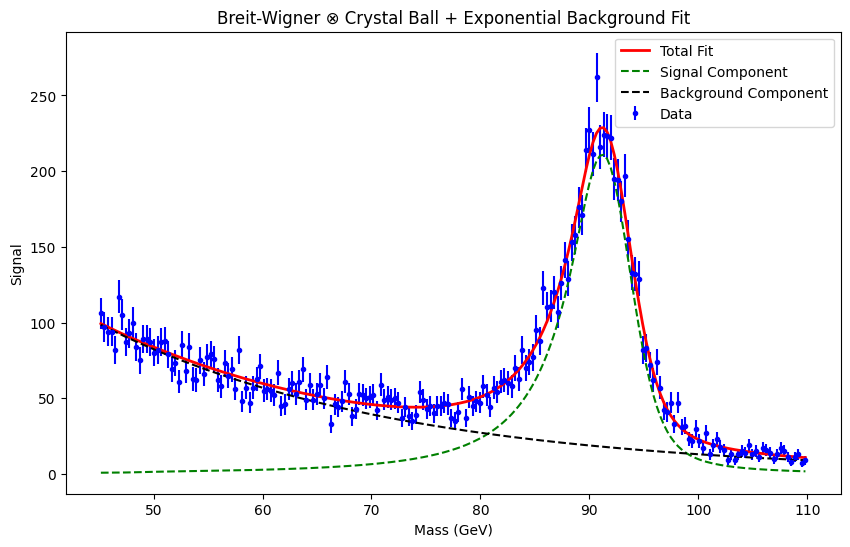

alpha: 0.8332
n: 3.2319
mean_cb: 77.5559
sigma_cb: 2.0213
scale: 540.3309
exp_scale: 522.0334
exp_coeff: 0.0369


In [4]:
popt, pcov = curve_fit(
    bm.signal_model,
    x,
    y,
    p0=[1.5, 5.0, 91.188, 1.5, 100, 200, 0.03]# Initial guesses
)

# Plot the data, fit, and components
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=y_errors, fmt='.', color="blue", label="Data")
#plt.scatter(x, y, color="blue", s=10, label="Data")
plt.plot(x, bm.signal_model(x, *popt), color="red", linewidth=2, label="Total Fit")

# Extract signal and background components separately for visualization
signal_fit = popt[4] * bm.bw_cb_convolution(x, *popt[:4])
background_fit = popt[5] * np.exp(-popt[6] * x)
plt.plot(x, signal_fit, 'g--', label="Signal Component")
plt.plot(x, background_fit, 'k--', label="Background Component")

plt.xlabel("Mass (GeV)")
plt.ylabel("Signal")
plt.legend()
plt.title("Breit-Wigner ⊗ Crystal Ball + Exponential Background Fit")
plt.show()

# Print fitted parameters
param_names = ["alpha", "n", "mean_cb", "sigma_cb", "scale", "exp_scale", "exp_coeff"]
for name, value in zip(param_names, popt):
    print(f"{name}: {value:.4f}")

In [27]:
#TODO Try different priors, eg more constrained mean, or more relaxed, etc

alpha, n, mean_cb, sigma_cb, scale, exp_scale, exp_coeff = popt

alpha_prior = scipy.stats.norm(loc=alpha, scale =0.0001*alpha)
#alpha_prior = scipy.stats.uniform(loc=0.7, scale=0.05)
n_prior = scipy.stats.norm(loc=n, scale=0.0001*n)
mean_cb_prior = scipy.stats.norm(loc=mean_cb, scale=0.01*mean_cb)
sigma_cb_prior = scipy.stats.norm(loc=sigma_cb, scale=0.0001*sigma_cb)
scale_prior = scipy.stats.norm(loc=scale, scale=0.01*scale)
exp_scale_prior = scipy.stats.norm(loc=exp_scale, scale=0.01*exp_scale)
exp_coeff_prior = scipy.stats.uniform(loc=0.020, scale=0.040)

# a1_prior = scipy.stats.norm(loc=200, scale=50)
# mu1_prior = scipy.stats.norm(loc=91.1, scale=2)
# sigma1_prior = scipy.stats.uniform(loc=2, scale=3)

# b_prior = scipy.stats.norm(loc=350, scale=100)
# k_prior = scipy.stats.uniform(loc=0.010, scale=0.040)

priors = [alpha_prior, n_prior, mean_cb_prior, sigma_cb_prior, scale_prior, exp_scale_prior, exp_coeff_prior]

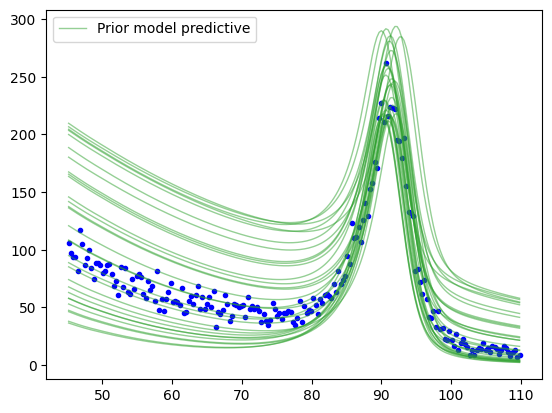

In [33]:
# Fix the pseudo random number generator seed for reproducibility
#np.random.seed(2)

# Evaluate the model at the prior sample parameters
prior_model_predictive = np.array(
    [bm.signal_model(x, *parameters) for parameters in bm.sample_prior(n_sample=30, priors=priors)]
)

#TODO add labels, legend, errorbars, further relevant stilyng

style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'blue')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

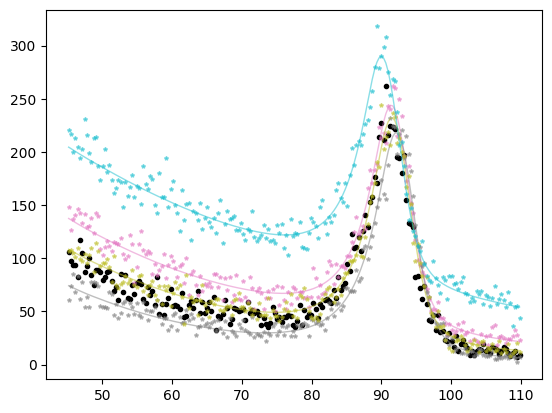

In [34]:
prior_predictive = np.random.poisson(lam=prior_model_predictive)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4, 8):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)

MAP results
[8.33150972e-01 3.23190530e+00 7.75558511e+01 2.02130818e+00
 5.40330877e+02 5.22033386e+02 3.69215025e-02]


c:\Users\ZenBook\Desktop\machine_learning\ML_tools\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:64: RuntimeWarning: invalid value encountered in power
  return np.where(z > -alpha, N * np.exp(-z**2 / 2), N * A * (B - z)**-n)
c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:64: RuntimeWarning: invalid value encountered in power
  return np.where(z > -alpha, N * np.exp(-z**2 / 2), N * A * (B - z)**-n)


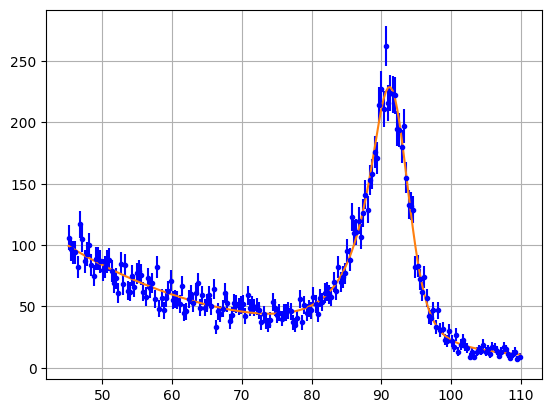

In [35]:
#TODO Same as before. Also plot the separate parts of the distribution, i.e the peak and background, see how they are
# defined in bm

MAP_result = scipy.optimize.minimize(
    fun=bm.negative_log_posterior,
    x0=popt,
    args=(x, y, y_errors, bm.signal_model, priors, 'poisson')
)
MAP_results = MAP_result.x


print("MAP results")
print(MAP_results)

plt.errorbar(x, y, yerr=y_errors, fmt ='.', color = 'b', label='Data')
plt.plot(x, bm.signal_model(x, *MAP_results), c="C1", label="MAP model")
plt.grid()


### Now sampling using emcee MCMC chains

In [36]:
np.random.seed(5)

# emcee requires some extra settings to run
n_param = 7       # Number of parameter we are sampling
n_walker = 30     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 5000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
# theta_init = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) \
#     + 0.1*np.random.normal(size=(n_walker, n_param))
    
theta_init = np.column_stack([
    alpha_prior.rvs(size=n_walker),
    n_prior.rvs(size=n_walker),
    mean_cb_prior.rvs(size=n_walker),
    sigma_cb_prior.rvs(size=n_walker),
    scale_prior.rvs(size=n_walker),
    exp_scale_prior.rvs(size=n_walker),
    exp_coeff_prior.rvs(size=n_walker)
])

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=bm.log_posterior_probability,
    args=(x, y, y_errors, bm.signal_model, priors, 'poisson')
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)


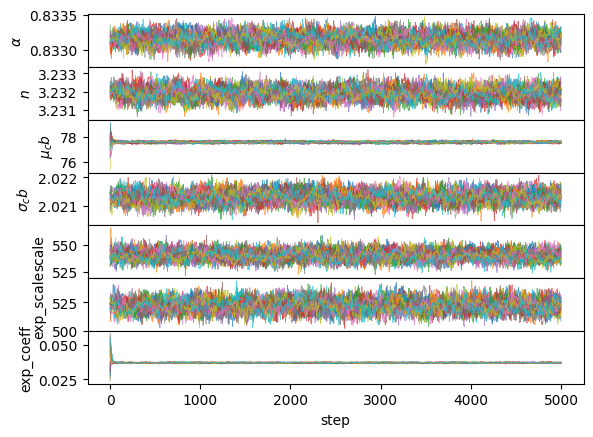

In [37]:
#chain = np.load('emcee_chain_gauss_exp_30_walker_2_10k.npy')
chain = sampler.get_chain()

n_walker = 30
param_names = [r"$\alpha$", r"$n$", r"$\mu_cb$", r"$\sigma_cb$", "scale", "exp_scale", "exp_coeff"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

### Integration time - quantitative check

In [38]:
tau = emcee.autocorr.integrated_time(chain)
print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
 print(f"{name}: {iat:.1f}")


Integrated auto-correlation time
$\alpha$: 76.7
$n$: 70.0
$\mu_cb$: 60.2
$\sigma_cb$: 85.6
scale: 65.6
exp_scale: 75.1
exp_coeff: 45.8


#### Discard the burnout

In [39]:
max_autocorr = max(tau)
burn_in = int(10*max_autocorr)
thin = int(max_autocorr/2)

n_param = 7
chain = chain[burn_in::thin].reshape(-1, n_param)

#chain = sampler.get_chain(discard=2000, thin=10, flat=True)


#### Now the corner plots for the "filtered" chain

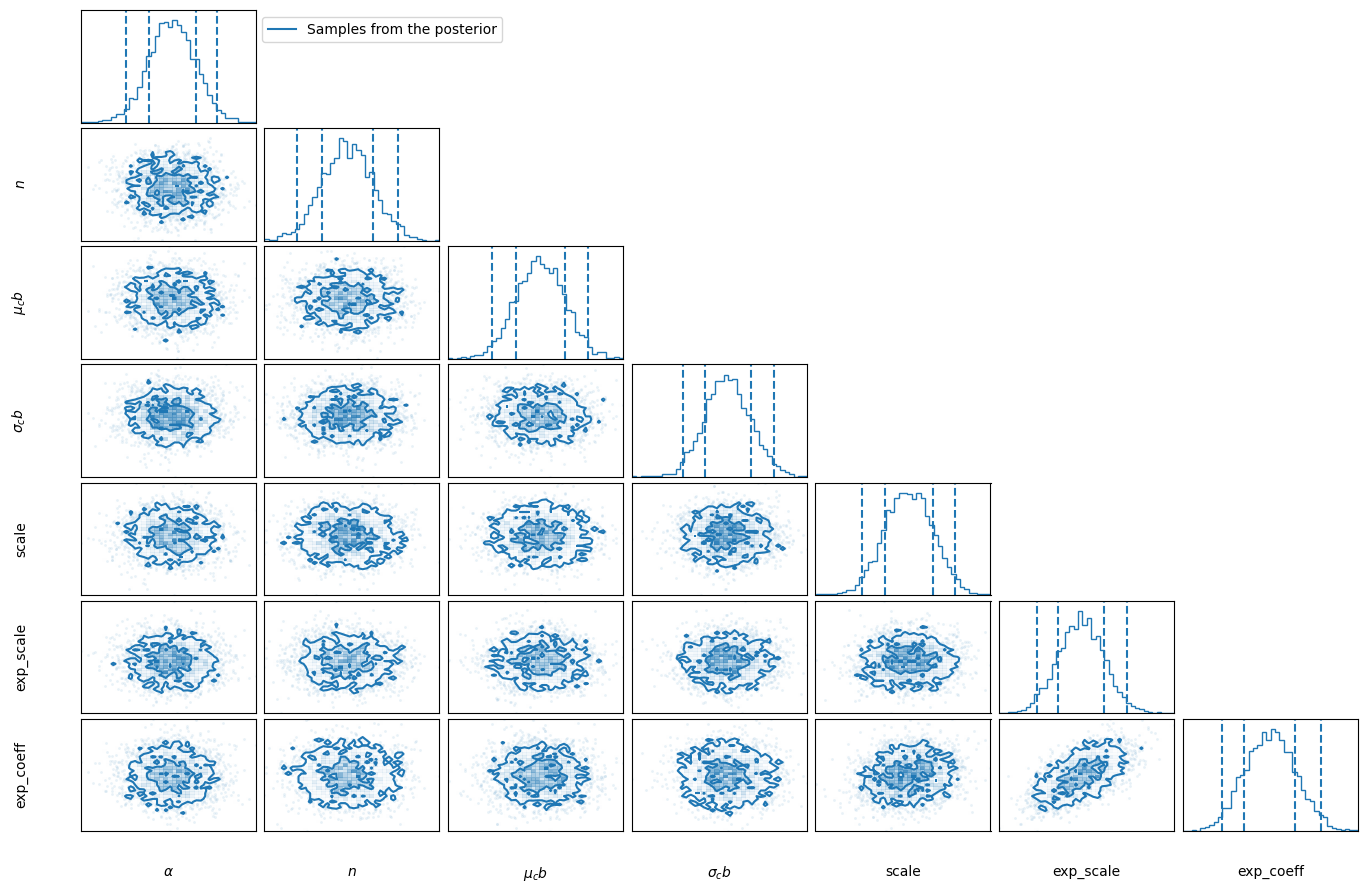

In [40]:
#TODO make it with your custom plotting, style it, proper tickmarks, check the quantiles

fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=[r"$\alpha$", r"$n$", r"$\mu_cb$", r"$\sigma_cb$", "scale", "exp_scale", "exp_coeff"],
    color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
)
fig.get_axes()[0].plot([], [], c="C0", label="Samples from the posterior")
#fig.get_axes()[0].plot([], [], c="C1", label="True parameters")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))

# for ax in fig.get_axes():
#     ax.xaxis.label.set_size(12)  # Optional: Adjust font size if needed
#     ax.yaxis.label.set_size(12)
#     ax.xaxis.labelpad = 30       # Adjust label padding for x-axis
#     ax.yaxis.labelpad = 30       # Adjust label padding for y-axis

for ax in fig.get_axes():
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

fig.set_size_inches(14, 9)



In [ ]:
# TODO Find here the mean and variance of each parameter from the MCMC chain

# Mark it also in the corner plots (advisable to implement it in the function)

#### Check how the samples look

<ErrorbarContainer object of 3 artists>

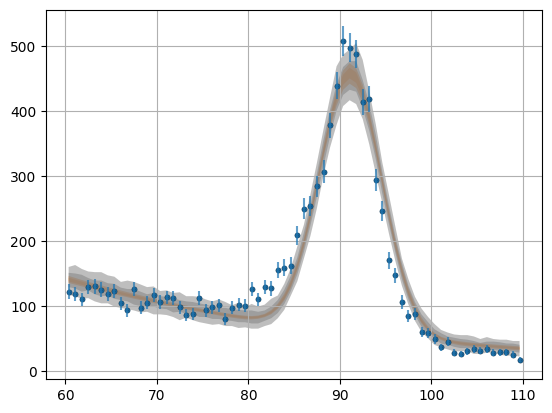

In [ ]:
# NOT RELEVANT ANYMORE, REPLACED BY THE NEXT CODEBLOCK

# Choose a small subsample of the chain for plotting purposes
#chain = np.load('emcee_chain_gauss_exp_30_walker_1.npy')
#chain = bm.process_chain(chain, discard=1000, thin=10, flat=True)

chain_samples, model_predictive = bm.sample_posterior(x, y, chain, bm.signal_model)

def predict(params, x):
    lambda_model = bm.signal_model(x, *params)
    lambda_model = np.maximum(lambda_model, 0)

    # Draw from the Poisson distribution using the computed lambda
    return np.random.poisson(lam=lambda_model)

posterior_predictive = np.array(
        [predict(sample, x) for sample in chain_samples])

quantiles = np.percentile(posterior_predictive, [2.5, 16, 84, 97.5], axis=0)

plt.fill_between(x, quantiles[0], quantiles[-1], alpha=0.5, facecolor="C17",
                    label="Model predictive distribution")
plt.fill_between(x, quantiles[1], quantiles[-2], alpha=0.5, facecolor="C17")
plt.errorbar(x, y, yerr=y_errors, fmt=".", color="C10", label="Data", alpha=0.7)


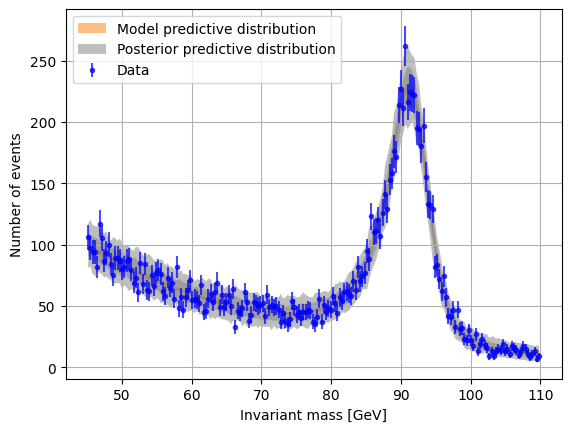

In [41]:
# Choose a small subsample of the chain for plotting purposes
#chain = np.load('emcee_chain_gauss_exp_30_walker_1.npy')
#chain = bm.process_chain(chain, discard=1000, thin=10, flat=True)

chain_samples, model_predictive, posterior_predictive = bm.sample_posterior(x, y, y_errors, chain, bm.signal_model, mode='poisson')

### Chi-squared goodness of fit - not relevant for Poisson distributed data

In [ ]:
# NOT RELEVANT 

sigma_y = 1
#print(y_errors)
def chi_squared(y, sigma_y, mu):
    return np.sum((y - mu)**2/sigma_y**2)

chi_squared_gauss_exp = chi_squared(y, 5*y_errors, bm.model_single_gauss_exp(x, *MAP_results))

n_data = len(y)

PTE = scipy.stats.chi2(df=n_data - n_param).sf(chi_squared_gauss_exp)

print(f"Gauss + Exp: χ²={chi_squared_gauss_exp:.1f}, "
 f"ndof={n_data}-{n_param}, PTE={PTE:.3f}")


Gauss + Exp: χ²=18.0, ndof=70-5, PTE=1.000


### Posterior predictive checks

In [42]:
def chi_squared(y, mu):
    return np.sum((y - mu)**2/mu)

def test_statistic(y, theta, x, model):
    mu = model(x, *theta)
    t = chi_squared(y, mu)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))
        
    t_data = np.array(t_data)
    t_rep = np.array(t_rep)
    
    # print(t_data)
    # print(t_rep)
    
    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data


In [43]:
ppd = posterior_predictive

PPD_PTE_gauss_exp, t_rep_gauss_exp, t_gauss_exp = ppd_model_check(
                                    test_statistic=lambda y, theta: test_statistic(y, theta, x, bm.signal_model),
                                    y=y,
                                    ppd=ppd,
                                    ppd_params=chain_samples
                                                                  )

print(f"Gauss + Exp: PPD PTE={PPD_PTE_gauss_exp:.3f}")

Gauss + Exp: PPD PTE=0.495


### Compute evidence - not relevant yet

In [44]:
import dynesty

log_likelihood_gauss_exp = lambda theta: bm.log_likelihood_poisson(x, y, bm.signal_model, theta)

def prior_transform_gauss_exp(u):
    x = np.array([
        alpha_prior.ppf(u[0]),
        n_prior.ppf(u[1]),            
        mean_cb_prior.ppf(u[2]),
        sigma_cb_prior.ppf(u[3]),
        scale_prior.ppf(u[4]),
        exp_scale_prior.ppf(u[5]),
        exp_coeff_prior.ppf(u[6])
    ])

    return x

sampler_gauss_exp = dynesty.NestedSampler(
    loglikelihood=log_likelihood_gauss_exp,
    prior_transform=prior_transform_gauss_exp,
    ndim=7,
    nlive=100,
)
sampler_gauss_exp.run_nested(print_progress=True)

sampler_gauss_exp.results.summary()

341it [00:03, 42.80it/s, bound: 0 | nc: 23 | ncall: 3282 | eff(%): 10.390 | loglstar:   -inf < -716.574 <    inf | logz: -723.535 +/-  0.247 | dlogz: 40.712 >  0.109]  c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:64: RuntimeWarning: invalid value encountered in power
  return np.where(z > -alpha, N * np.exp(-z**2 / 2), N * A * (B - z)**-n)
378it [00:03, 74.26it/s, bound: 1 | nc: 19 | ncall: 3653 | eff(%): 10.348 | loglstar:   -inf < -705.182 <    inf | logz: -712.469 +/-  0.245 | dlogz: 29.780 >  0.109]c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:64: RuntimeWarning: invalid value encountered in power
  return np.where(z > -alpha, N * np.exp(-z**2 / 2), N * A * (B - z)**-n)
393it [00:03, 89.41it/s, bound: 2 | nc: 5 | ncall: 3725 | eff(%): 10.550 | loglstar:   -inf < -700.187 <    inf | logz: -707.272 +/-  0.251 | dlogz: 24.401 >  0.109] c:\Users\ZenBook\Desktop\bayesian\proiect bayesian\bayesian_model.py:64: RuntimeWarning: invalid value e

Summary
nlive: 100
niter: 930
ncall: 6081
eff(%): 16.938
logz: -685.865 +/-  0.288


#### Save the not filtered chain if satisfied

In [68]:
np.save('emcee_chain_breit_wigner_cb_1.npy', sampler.get_chain())

### Looking at the residuals

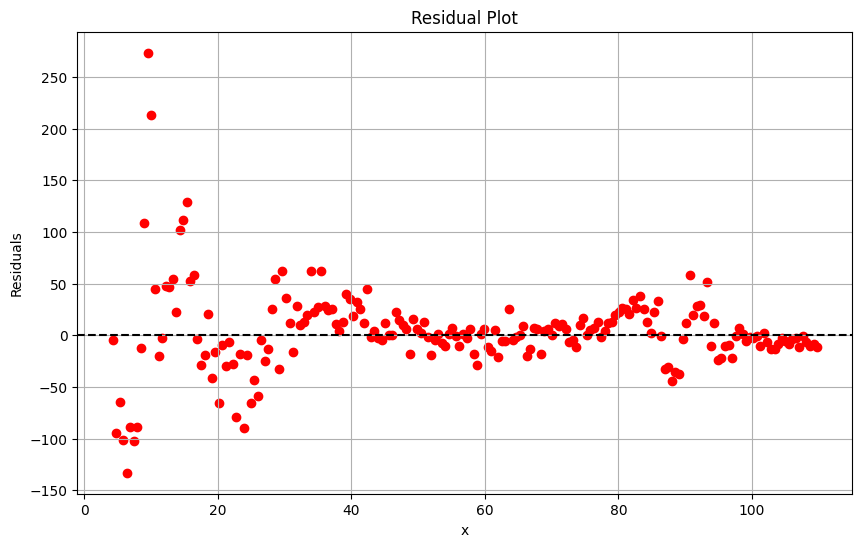

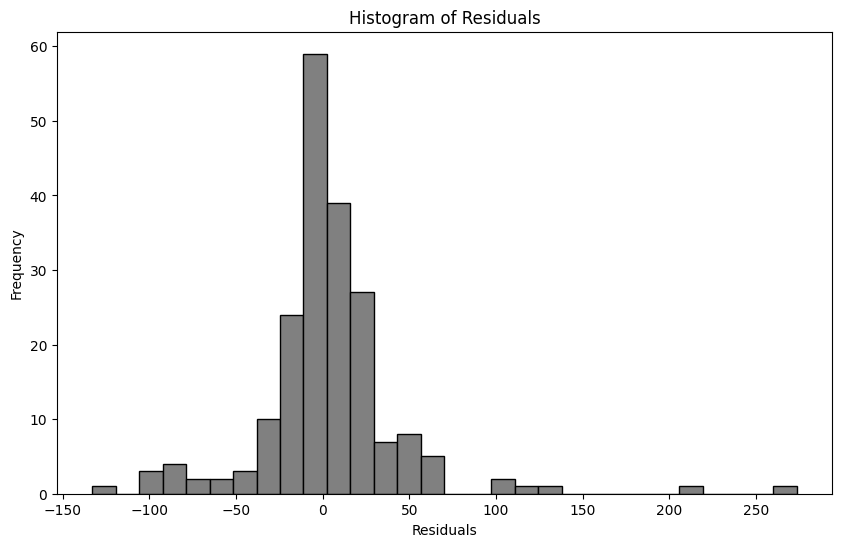

In [239]:
mu = bm.model_gauss_exp(x, *MAP_results)
residuals = y - mu


plt.figure(figsize=(10, 6))
plt.scatter(x, residuals, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Optionally, you can plot a histogram of the residuals to inspect their distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='gray', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()